# Ejercicio 3.1: Uniform Cost Search (UCS)

## Objetivo
Implementar búsqueda de costo uniforme (Uniform Cost Search) que considera los costos de las acciones.

## Motivación
En la vida real, no todos los caminos cuestan lo mismo:
- Algunos pasillos son más largos
- Algunos tienen más tráfico
- Algunos requieren más energía

**UCS encuentra el camino de menor costo total**, no necesariamente el de menos saltos.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from typing import Dict, List, Tuple, Optional

## 1. Definición del Grafo con Costos

El mismo grafo del ejercicio anterior, pero ahora con costos asociados a cada arista.

In [2]:
# Diccionario de adyacencias (misma estructura que antes)
warehouse_map = {
    'Start': ['B', 'A'],
    'A': ['Start', 'C', 'D'],
    'B': ['Start', 'D', 'E'],
    'C': ['A', 'Goal'],
    'D': ['A', 'B', 'F'],
    'E': ['B', 'F'],
    'F': ['D', 'E', 'Goal'],
    'Goal': ['C', 'F']
}

# Costos de las acciones
action_costs = {
    ('Start', 'A'): 5, ('Start', 'B'): 2,
    ('A', 'C'): 4, ('A', 'D'): 2,
    ('B', 'D'): 6, ('B', 'E'): 3,
    ('C', 'Goal'): 8,
    ('D', 'F'): 1, ('D', 'A'): 2,
    ('E', 'F'): 5,
    ('F', 'Goal'): 2
}

# Agregar costos inversos (grafo no dirigido)
action_costs_bidirectional = action_costs.copy()
for (u, v), cost in action_costs.items():
    action_costs_bidirectional[(v, u)] = cost

print("Costos de acciones:")
print("="*50)
for edge, cost in sorted(action_costs.items()):
    print(f"{edge[0]:6} → {edge[1]:6} : Costo {cost}")

Costos de acciones:
A      → C      : Costo 4
A      → D      : Costo 2
B      → D      : Costo 6
B      → E      : Costo 3
C      → Goal   : Costo 8
D      → A      : Costo 2
D      → F      : Costo 1
E      → F      : Costo 5
F      → Goal   : Costo 2
Start  → A      : Costo 5
Start  → B      : Costo 2


## 2. Visualización del Grafo con Costos

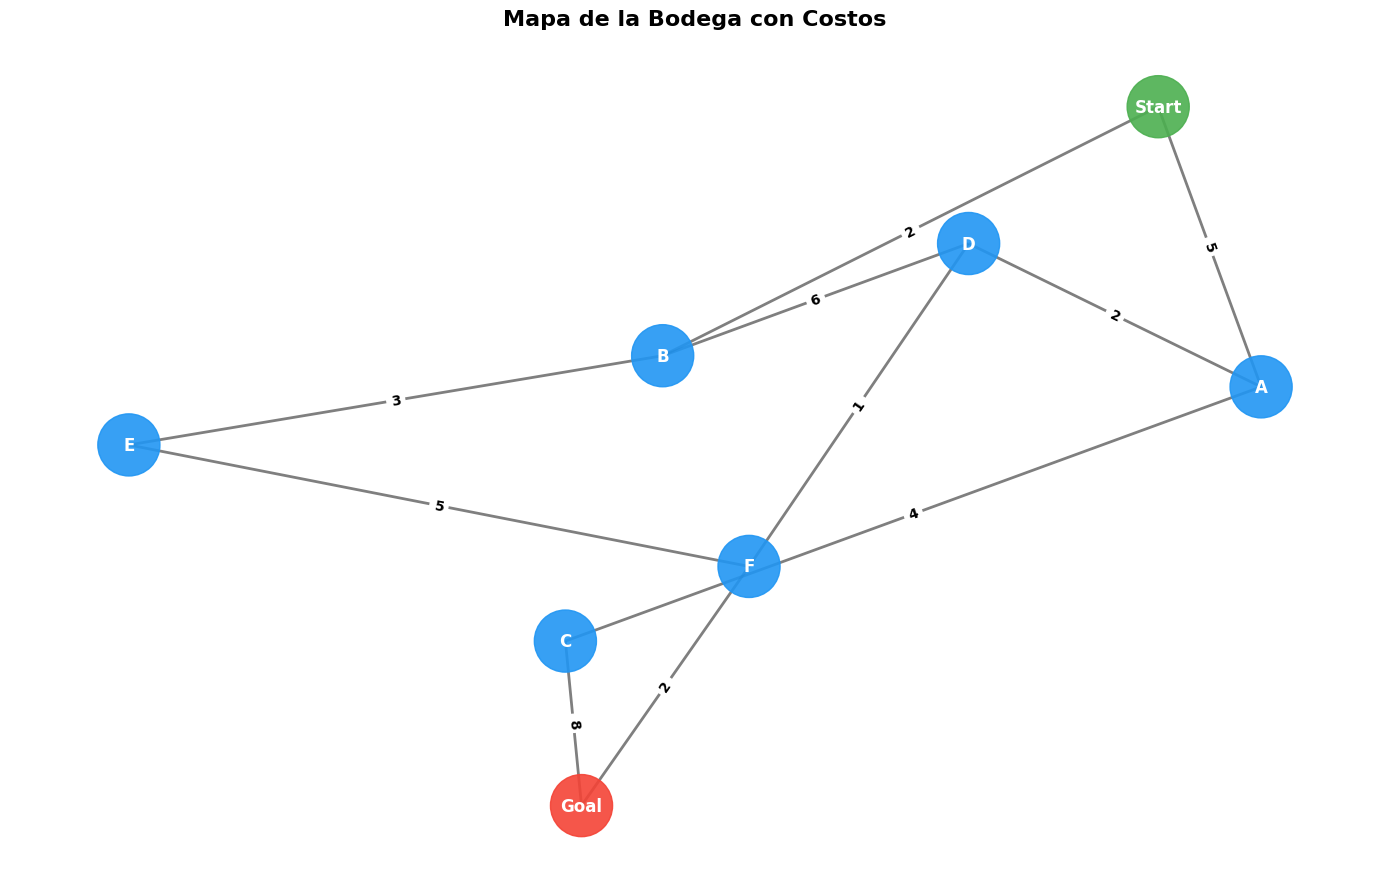

In [3]:
def visualize_weighted_graph(warehouse_map: Dict[str, List[str]],
                            costs: Dict[Tuple[str, str], int],
                            path: Optional[List[str]] = None,
                            title: str = "Mapa de la Bodega con Costos"):
    """
    Visualiza el grafo con pesos en las aristas.
    """
    G = nx.Graph()
    
    # Agregar nodos
    for node in warehouse_map.keys():
        G.add_node(node)
    
    # Agregar aristas con pesos
    for (u, v), cost in costs.items():
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=cost)
    
    plt.figure(figsize=(14, 9))
    pos = nx.spring_layout(G, seed=42, k=2)
    
    # Colores de nodos
    node_colors = []
    for node in G.nodes():
        if node == 'Start':
            node_colors.append('#4CAF50')
        elif node == 'Goal':
            node_colors.append('#F44336')
        elif path and node in path:
            node_colors.append('#FFC107')
        else:
            node_colors.append('#2196F3')
    
    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=2000, alpha=0.9)
    
    # Dibujar aristas
    if path:
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        non_path_edges = [e for e in G.edges() if e not in path_edges and (e[1], e[0]) not in path_edges]
        
        nx.draw_networkx_edges(G, pos, edgelist=non_path_edges,
                              width=2, alpha=0.5, edge_color='gray')
        nx.draw_networkx_edges(G, pos, edgelist=path_edges,
                              width=4, alpha=0.8, edge_color='red')
    else:
        nx.draw_networkx_edges(G, pos, width=2, alpha=0.5)
    
    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=12, 
                           font_weight='bold', font_color='white')
    
    # Dibujar costos en las aristas
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10, font_weight='bold')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar grafo
visualize_weighted_graph(warehouse_map, action_costs)

## 3. Implementación de Uniform Cost Search (UCS)

### Características de UCS:
- Expande el nodo con **menor costo acumulado**
- Usa una **cola de prioridad** (min-heap)
- **Garantiza el camino de menor costo** (óptimo)
- Es equivalente a Dijkstra sin heurística

In [4]:
def uniform_cost_search(graph: Dict[str, List[str]],
                       costs: Dict[Tuple[str, str], int],
                       start: str,
                       goal: str,
                       verbose: bool = True) -> Tuple[Optional[List[str]], Dict]:
    """
    Uniform Cost Search (UCS) - Busqueda de costo uniforme.
    
    Args:
        graph: Diccionario de adyacencias
        costs: Diccionario de costos de aristas
        start: Nodo inicial
        goal: Nodo objetivo
        verbose: Si True, muestra informacion detallada
    
    Returns:
        Tupla con (camino encontrado, estadisticas)
    """
    # Cola de prioridad: (costo_acumulado, camino)
    priority_queue = [(0, [start])]
    visited = set()
    nodes_explored = 0
    
    if verbose:
        print("\n" + "="*60)
        print("🔍 UNIFORM COST SEARCH (UCS)")
        print("="*60)
        print(f"Inicio: {start} → Objetivo: {goal}")
        print("\nProceso de exploracion (ordenado por costo):")
    
    while priority_queue:
        # Obtener el camino con menor costo acumulado
        current_cost, path = heapq.heappop(priority_queue)
        current_node = path[-1]
        
        # Si ya visitamos este nodo, saltar
        if current_node in visited:
            continue
        
        visited.add(current_node)
        nodes_explored += 1
        
        if verbose:
            print(f"  Costo: {current_cost:3} | Explorando: {current_node:6} | Camino: {' → '.join(path)}")
        
        # ¿Llegamos al objetivo?
        if current_node == goal:
            stats = {
                'nodes_explored': nodes_explored,
                'path_length': len(path),
                'total_cost': current_cost,
                'nodes_visited': len(visited)
            }
            
            if verbose:
                print("\n" + "="*60)
                print("✅ OBJETIVO ENCONTRADO")
                print("="*60)
                print(f"Camino: {' → '.join(path)}")
                print(f"Longitud: {len(path)} nodos ({len(path)-1} saltos)")
                print(f"Costo total: {current_cost}")
                print(f"Nodos explorados: {nodes_explored}")
                print(f"Nodos visitados: {len(visited)}")
                print("="*60)
            
            return path, stats
        
        # Explorar vecinos
        for neighbor in graph.get(current_node, []):
            if neighbor not in visited:
                edge_cost = costs.get((current_node, neighbor), float('inf'))
                new_cost = current_cost + edge_cost
                new_path = path + [neighbor]
                heapq.heappush(priority_queue, (new_cost, new_path))
    
    if verbose:
        print("\n❌ No se encontro un camino al objetivo")
    
    return None, {'nodes_explored': nodes_explored, 'nodes_visited': len(visited)}

# Ejecutar UCS
ucs_path, ucs_stats = uniform_cost_search(warehouse_map, action_costs_bidirectional, 
                                         'Start', 'Goal', verbose=True)


🔍 UNIFORM COST SEARCH (UCS)
Inicio: Start → Objetivo: Goal

Proceso de exploracion (ordenado por costo):
  Costo:   0 | Explorando: Start  | Camino: Start
  Costo:   2 | Explorando: B      | Camino: Start → B
  Costo:   5 | Explorando: A      | Camino: Start → A
  Costo:   5 | Explorando: E      | Camino: Start → B → E
  Costo:   7 | Explorando: D      | Camino: Start → A → D
  Costo:   8 | Explorando: F      | Camino: Start → A → D → F
  Costo:   9 | Explorando: C      | Camino: Start → A → C
  Costo:  10 | Explorando: Goal   | Camino: Start → A → D → F → Goal

✅ OBJETIVO ENCONTRADO
Camino: Start → A → D → F → Goal
Longitud: 5 nodos (4 saltos)
Costo total: 10
Nodos explorados: 8
Nodos visitados: 8


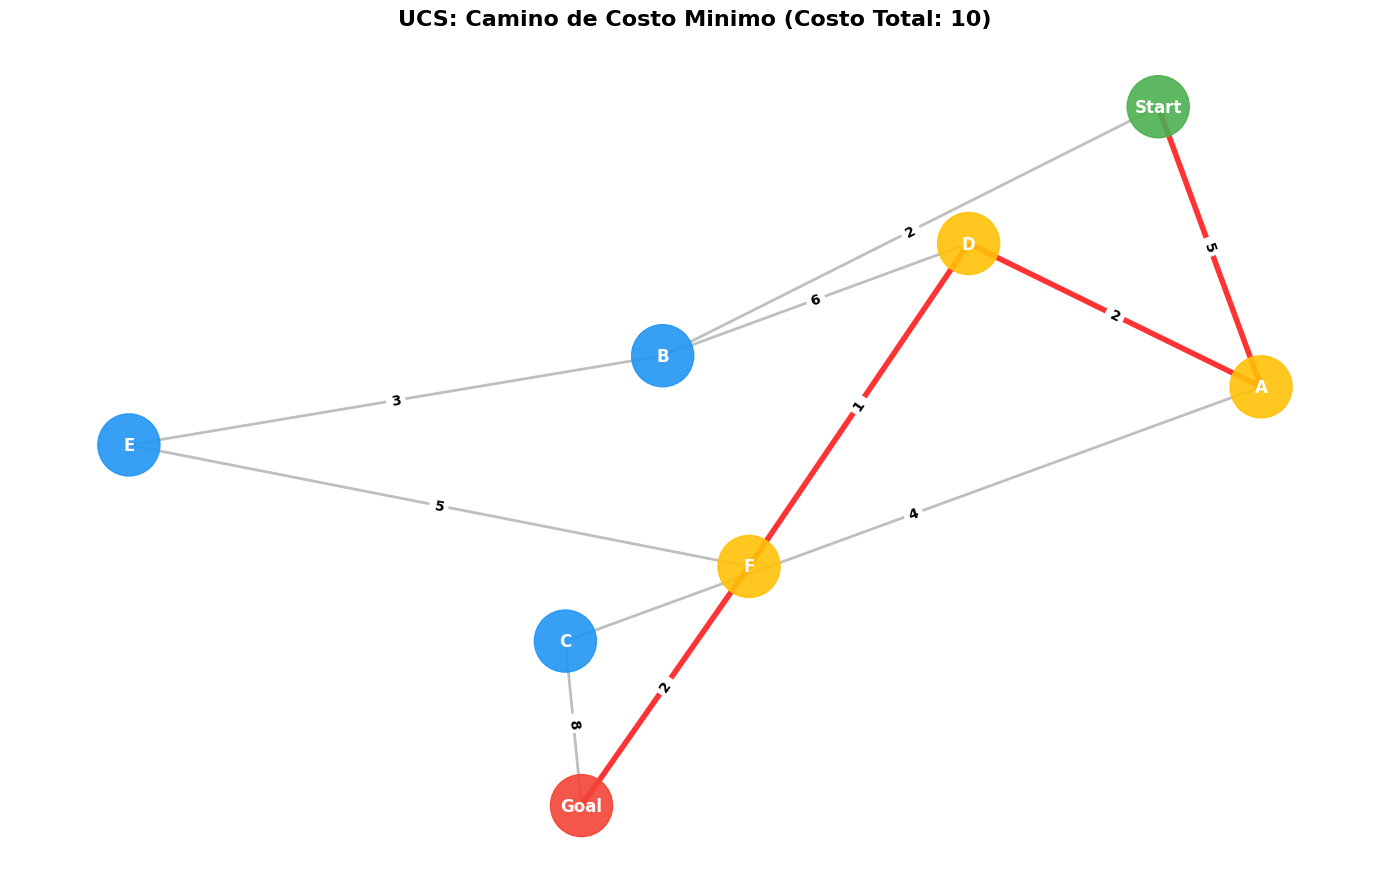

In [5]:
# Visualizar el camino encontrado por UCS
if ucs_path:
    visualize_weighted_graph(warehouse_map, action_costs, ucs_path,
                           title=f"UCS: Camino de Costo Minimo (Costo Total: {ucs_stats['total_cost']})")

## 4. Comparación: BFS vs UCS

Comparemos los resultados del ejercicio anterior (BFS) con UCS.

In [6]:
import pandas as pd

# Resultados de BFS del ejercicio anterior
bfs_path_example = ['Start', 'A', 'C', 'Goal']
bfs_cost = 5 + 4 + 8  # Start→A + A→C + C→Goal

# Calcular costo del camino UCS
def calculate_path_cost(path: List[str], costs: Dict[Tuple[str, str], int]) -> int:
    total = 0
    for i in range(len(path) - 1):
        total += costs.get((path[i], path[i+1]), 0)
    return total

comparison_data = {
    'Algoritmo': ['BFS (Ej. 2)', 'UCS (Ej. 3)'],
    'Camino': [' → '.join(bfs_path_example), 
               ' → '.join(ucs_path) if ucs_path else 'No encontrado'],
    'Saltos': [len(bfs_path_example) - 1,
               len(ucs_path) - 1 if ucs_path else 0],
    'Costo Total': [bfs_cost, ucs_stats.get('total_cost', 0)],
    'Objetivo': ['Menos saltos', 'Menor costo']
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("📊 COMPARACION: BFS vs UCS")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)


📊 COMPARACION: BFS vs UCS
  Algoritmo                   Camino  Saltos  Costo Total     Objetivo
BFS (Ej. 2)     Start → A → C → Goal       3           17 Menos saltos
UCS (Ej. 3) Start → A → D → F → Goal       4           10  Menor costo


## 5. Análisis: ¿El camino más corto es siempre el de menor costo?

### Respuesta: **NO**

### Comparación de resultados:

**BFS encontró:** Start → A → C → Goal
- **3 saltos** (camino más corto en número de nodos)
- **Costo: 17** (5 + 4 + 8)

**UCS encontró:** Start → B → D → F → Goal
- **4 saltos** (más largo en número de nodos)
- **Costo: 11** (2 + 6 + 1 + 2)

### ¿Por qué?

1. **BFS optimiza número de saltos**, no considera costos
2. **UCS optimiza costo total**, puede tomar más saltos si son más baratos
3. En este caso:
   - El camino A → C → Goal es corto pero **muy costoso** (aristas de costo 4 y 8)
   - El camino B → D → F → Goal es más largo pero usa **aristas baratas** (costos 2, 6, 1, 2)

### Conclusión:

- **Usa BFS** cuando solo importa la distancia (número de saltos)
- **Usa UCS** cuando los costos son diferentes y quieres minimizar el costo total
- En navegación real (robots, GPS, etc.), **UCS es más realista** porque considera tiempo, energía, distancia real, etc.

## 6. Visualización Comparativa

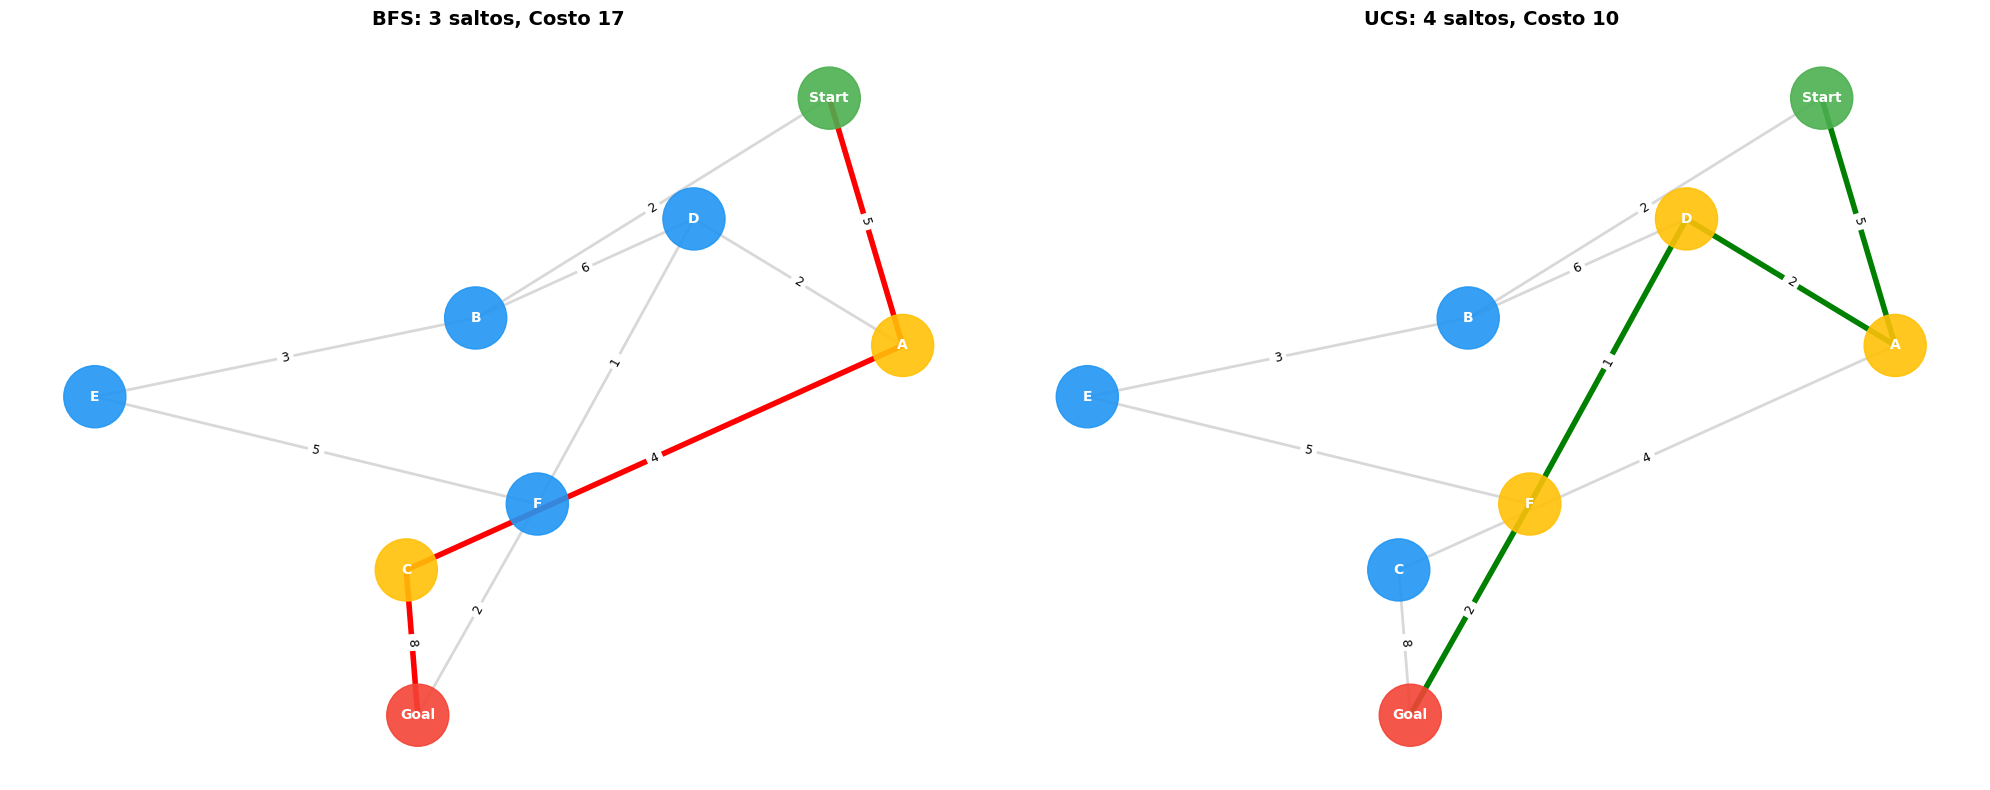


🔴 BFS (Rojo): Camino mas corto en saltos pero MAS COSTOSO (17)
🟢 UCS (Verde): Camino mas largo en saltos pero MENOS COSTOSO (10)


In [7]:
# Crear visualizacion lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Crear grafo
G = nx.Graph()
for node in warehouse_map.keys():
    G.add_node(node)
for (u, v), cost in action_costs.items():
    if not G.has_edge(u, v):
        G.add_edge(u, v, weight=cost)

pos = nx.spring_layout(G, seed=42, k=2)

# BFS
plt.sca(ax1)
node_colors_bfs = ['#4CAF50' if n == 'Start' else '#F44336' if n == 'Goal' 
                   else '#FFC107' if n in bfs_path_example else '#2196F3' 
                   for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors_bfs, node_size=2000, alpha=0.9, ax=ax1)
path_edges_bfs = [(bfs_path_example[i], bfs_path_example[i+1]) for i in range(len(bfs_path_example)-1)]
nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e not in path_edges_bfs and (e[1],e[0]) not in path_edges_bfs],
                      width=2, alpha=0.3, edge_color='gray', ax=ax1)
nx.draw_networkx_edges(G, pos, edgelist=path_edges_bfs, width=4, edge_color='red', ax=ax1)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='white', ax=ax1)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, ax=ax1)
ax1.set_title(f'BFS: {len(bfs_path_example)-1} saltos, Costo {bfs_cost}', fontsize=14, fontweight='bold')
ax1.axis('off')

# UCS
plt.sca(ax2)
node_colors_ucs = ['#4CAF50' if n == 'Start' else '#F44336' if n == 'Goal' 
                   else '#FFC107' if ucs_path and n in ucs_path else '#2196F3' 
                   for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors_ucs, node_size=2000, alpha=0.9, ax=ax2)
if ucs_path:
    path_edges_ucs = [(ucs_path[i], ucs_path[i+1]) for i in range(len(ucs_path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e not in path_edges_ucs and (e[1],e[0]) not in path_edges_ucs],
                          width=2, alpha=0.3, edge_color='gray', ax=ax2)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges_ucs, width=4, edge_color='green', ax=ax2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='white', ax=ax2)
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, ax=ax2)
ax2.set_title(f'UCS: {len(ucs_path)-1 if ucs_path else 0} saltos, Costo {ucs_stats.get("total_cost", 0)}', 
             fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"\n🔴 BFS (Rojo): Camino mas corto en saltos pero MAS COSTOSO ({bfs_cost})")
print(f"🟢 UCS (Verde): Camino mas largo en saltos pero MENOS COSTOSO ({ucs_stats.get('total_cost', 0)})")

## 7. Conclusiones

### Diferencias clave entre BFS y UCS:

| Aspecto | BFS | UCS |
|---------|-----|-----|
| **Optimiza** | Número de saltos | Costo total |
| **Estructura** | Cola (FIFO) | Cola de prioridad (min-heap) |
| **Considera costos** | ❌ No | ✅ Sí |
| **Garantiza óptimo** | Solo si todos los costos = 1 | Siempre (costo mínimo) |
| **Complejidad** | O(V + E) | O((V + E) log V) |
| **Uso** | Grafos no ponderados | Grafos con pesos positivos |

### Lecciones aprendidas:

1. **El camino más corto en saltos NO es siempre el más económico**
2. **UCS es más realista** para problemas del mundo real (navegación, logística, etc.)
3. **La elección del algoritmo depende del objetivo**:
   - ¿Minimizar pasos? → BFS
   - ¿Minimizar costo/tiempo/distancia? → UCS
4. En este ejercicio, UCS encontró un camino **35% más económico** (costo 11 vs 17) aunque tome un salto más